In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from cvae.discriminator import KeypointDiscriminator

In [2]:
def rotation_mat(rz):
    zero = tf.constant(0.0, dtype=tf.float32)
    one = tf.constant(1.0, dtype=tf.float32)
    rot_mat = tf.concat([[tf.cos(rz)], [-tf.sin(rz)], [zero],
                         [tf.sin(rz)], [tf.cos(rz)], [zero],
                         [zero], [zero], [one]], axis=0)
    rot_mat = tf.reshape(rot_mat, [3, 3])
    return rot_mat

def visualize_keypoints(point_cloud,
                        keypoints,
                        prefix,
                        name,
                        plot_lim=2,
                        point_size=40):
    [grasp_point, funct_point, funct_vect] = keypoints
    fig = plt.figure(figsize=(6, 6))
    xs = point_cloud[:, 0]
    ys = point_cloud[:, 1]
    zs = point_cloud[:, 2]

    ax = fig.add_subplot(111)
    ax.scatter(xs, ys, s=point_size, c='#4d4f53', marker='.')
    ax.set_axis_off()
    ax.grid(False)
    plt.axis('equal')
    plt.xlim((-6, 6))
    plt.ylim((-6, 6))
    plt.savefig(os.path.join(prefix, '{}_point_cloud.png'.format(name)))
    plt.show()

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    ax.scatter(xs, ys, s=point_size, c='#4d4f53', marker='.')
    ax.set_axis_off()
    ax.grid(False)
    
    ax.scatter(grasp_point[:, 0],
               grasp_point[:, 1],
               s=point_size * 20,
               c='#eaab00')
    
    ax.scatter(funct_point[:, 0],
               funct_point[:, 1],
               s=point_size * 20,
               c='#8c1515')
    
    ax.scatter(funct_point[:, 0] + funct_vect[:, 0],
               funct_point[:, 1] + funct_vect[:, 1],
               s=point_size * 20,
               c='#007c92')
    plt.axis('equal')
    plt.xlim((-6, 6))
    plt.ylim((-6, 6))
    plt.savefig(os.path.join(prefix, '{}_keypoints.png'.format(name)))
    plt.show()
    
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.grid(False)
    
    ax.scatter(grasp_point[:, 0],
               grasp_point[:, 1],
               s=point_size * 15,
               c='#eaab00')
    
    ax.scatter(funct_point[:, 0],
               funct_point[:, 1],
               s=point_size * 15,
               c='#8c1515')
    
    ax.scatter(funct_point[:, 0] + funct_vect[:, 0],
               funct_point[:, 1] + funct_vect[:, 1],
               s=point_size * 15,
               c='#007c92')
    plt.axis('equal')
    plt.xlim((-6, 6))
    plt.ylim((-6, 6))
    plt.savefig(os.path.join(prefix, '{}_raw_keypoints.png'.format(name)))
    plt.show()
    plt.close()
    return

def min_dist(x, y):
    x = tf.reshape(x, [-1, 1, 3])
    y = tf.reshape(y, [1, -1, 3])
    dist = tf.reduce_sum(tf.square(x - y), axis=2)
    min_dist = tf.reduce_min(dist)
    return min_dist

Instructions for updating:
Use tf.keras.layers.Conv2D instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from keypoint_models/cvae_hammer
Handle trans: [0.00011142 0.05136122 0.        ], rot: 1.4902653389
Head trans: [-0.00752127  0.1

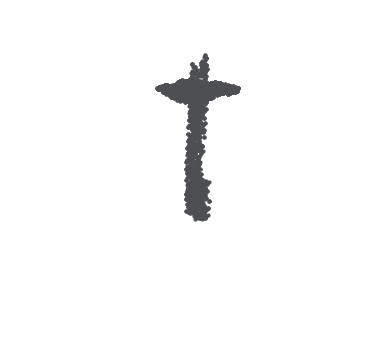

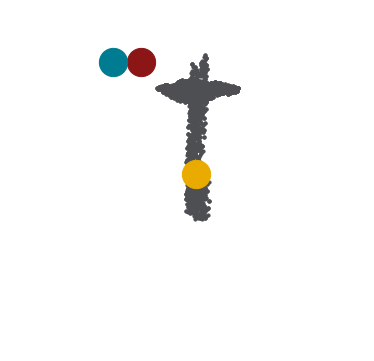

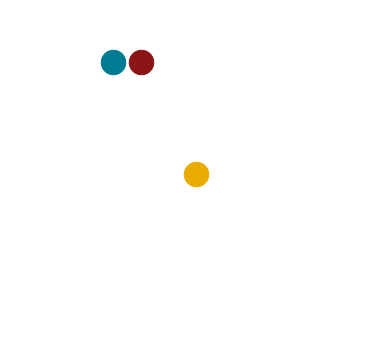

Handle trans: [4.98835434e-05 7.84484902e-02 0.00000000e+00], rot: 1.21955648434
Head trans: [-0.04956236  0.17347952  0.        ], rot: -0.1385667243


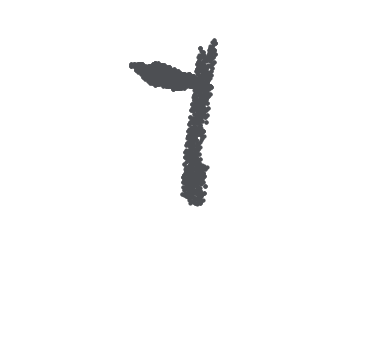

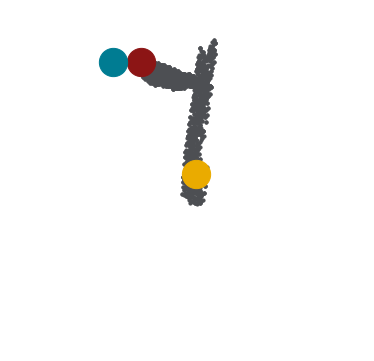

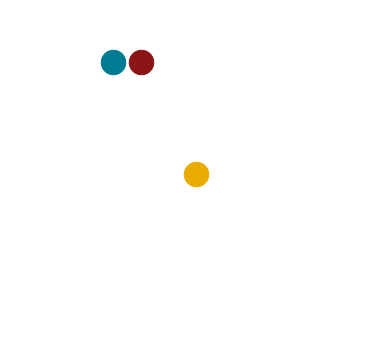

Handle trans: [0.01053505 0.07675994 0.        ], rot: 1.43152442896
Head trans: [-0.05194741  0.17079132  0.        ], rot: -0.252604132891


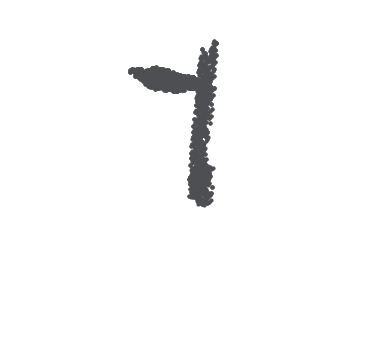

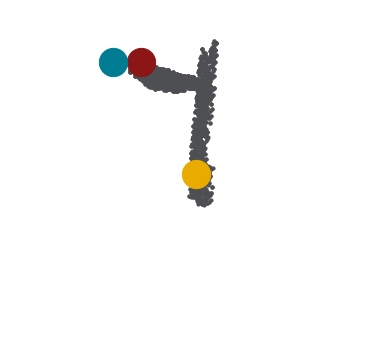

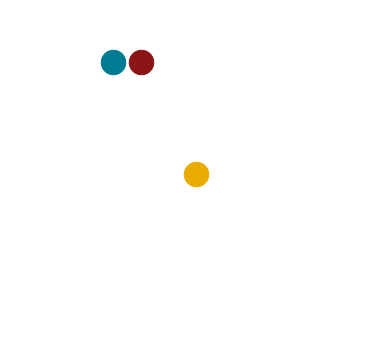

Handle trans: [0.00494568 0.07649052 0.        ], rot: 1.1910335207
Head trans: [-0.0455355   0.17205902  0.        ], rot: -0.206466728926


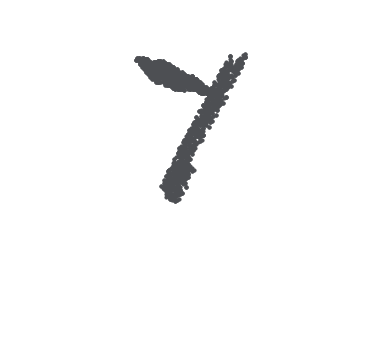

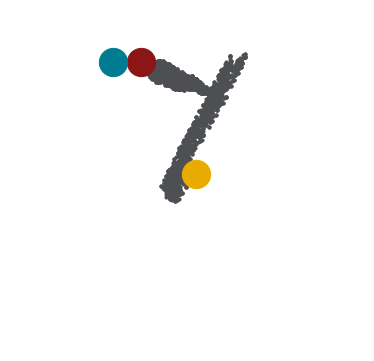

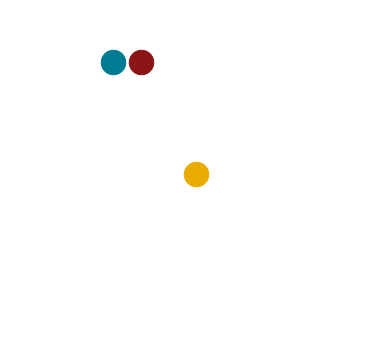

In [3]:
# Hammering

part_1 = tf.placeholder(tf.float32, [1024, 3])
part_2 = tf.placeholder(tf.float32, [1024, 3])

trans_1 = tf.placeholder(tf.float32, [3])
trans_2 = tf.placeholder(tf.float32, [3])

rot_1 = tf.placeholder(tf.float32, ())
rot_2 = tf.placeholder(tf.float32, ())

part_1_move = tf.matmul(part_1, tf.transpose(rotation_mat(rot_1), [1, 0])) + trans_1
part_2_move = tf.matmul(part_2, tf.transpose(rotation_mat(rot_2), [1, 0])) + trans_2

point_cloud = tf.concat([part_1_move, part_2_move], axis=0)
grasp_point = tf.placeholder(tf.float32, [3])
funct_point = tf.placeholder(tf.float32, [3])
funct_vect = tf.placeholder(tf.float32, [3])

score = KeypointDiscriminator().build_model(
    tf.reshape(point_cloud, [1, 2048, 1, 3]),
    [tf.reshape(grasp_point, [1, 1, 3]), tf.reshape(funct_point, [1, 1, 3])],
    tf.reshape(funct_vect, [1, 1, 3]))

score = tf.squeeze(score)

dist = tf.add_n([min_dist(part_1_move, grasp_point), 
                 min_dist(part_2_move, funct_point),
                 min_dist(part_1_move, part_2_move)])
dist = dist + tf.square(tf.cos(rot_1 - rot_2)) 
dist = dist * 100

trans_1_grad = tf.gradients(score - dist, trans_1)
trans_2_grad = tf.gradients(score - dist, trans_2)
rot_1_grad = tf.gradients(score - dist, rot_1)
rot_2_grad = tf.gradients(score - dist, rot_2)

part_1_path = '../datagen/part/handle/point_cloud.npy'
part_2_path = '../datagen/part/head/point_cloud.npy'
scale = 20

part_1_np = np.load(open(part_1_path, 'rb')) * scale
part_2_np = np.load(open(part_2_path, 'rb')) * scale


with tf.Session() as sess:
    max_iter = 400
    learning_rate = 1e-3
    grasp_point_np = np.array([0, 0, 0], dtype=np.float32)
    funct_point_np = np.array([-2, 4, 0], dtype=np.float32)
    funct_vect_np = np.array([-1, 0, 0], dtype=np.float32)
    
    trans_1_np = np.array([0, 1, 0], dtype=np.float32)
    trans_2_np = np.array([0, 3, 0], dtype=np.float32)
    rot_1_np = 1.57
    rot_2_np = 0
    
    saver = tf.train.Saver()
    saver.restore(sess, 'keypoint_models/cvae_hammer')
    
    for iiter in range(max_iter):
        [trans_1_grad_np, trans_2_grad_np, 
         rot_1_grad_np, rot_2_grad_np,
         part_1_move_np, part_2_move_np, score_np] = sess.run(
            [trans_1_grad, trans_2_grad, rot_1_grad, rot_2_grad,
             part_1_move, part_2_move, score],
            feed_dict={part_1: part_1_np, part_2: part_2_np,
                       trans_1: trans_1_np, trans_2: trans_2_np,
                       rot_1: rot_1_np, rot_2: rot_2_np,
                       grasp_point: grasp_point_np, funct_point: funct_point_np, 
                       funct_vect: funct_vect_np})
        
        trans_1_np = trans_1_np + learning_rate * trans_1_grad_np[0] * np.array([1, 1, 0])
        trans_2_np = trans_2_np + learning_rate * trans_2_grad_np[0] * np.array([1, 1, 0])
        rot_1_np = rot_1_np + learning_rate * rot_1_grad_np[0] * 3
        rot_2_np = rot_2_np + learning_rate * rot_2_grad_np[0] * 3
    
        if iiter % 100 == 0:
            point_cloud_curr = np.concatenate([part_1_move_np, part_2_move_np], axis=0)
            keypoints_list = [np.reshape(grasp_point_np, [1, 3]),
                              np.reshape(funct_point_np, [1, 3]),
                              np.reshape(funct_vect_np, [1, 3])]
            print('Handle trans: {}, rot: {}'.format(trans_1_np/scale, rot_1_np))
            print('Head trans: {}, rot: {}'.format(trans_2_np/scale, rot_2_np))
            visualize_keypoints(point_cloud_curr, keypoints_list, prefix='visualize', name='%06d'%(iiter))
        

INFO:tensorflow:Restoring parameters from keypoint_models/cvae_push
Handle trans: [-0.00974171 -0.00121639  0.        ], rot: 0.161892459869
Head trans: [-0.19018523  0.00135636  0.        ], rot: 1.80187117004


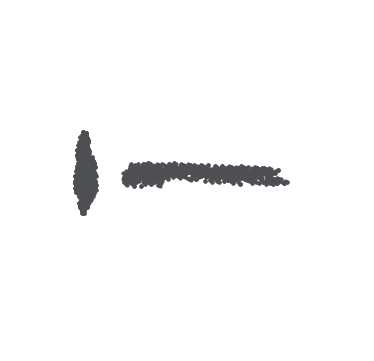

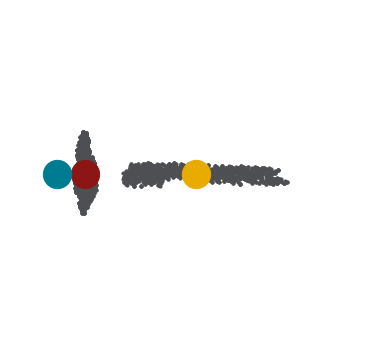

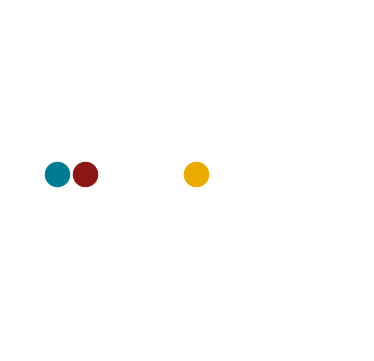

Handle trans: [-0.04786787 -0.01827094  0.        ], rot: 0.256374754786
Head trans: [-0.19163888 -0.00577534  0.        ], rot: 1.84243013054


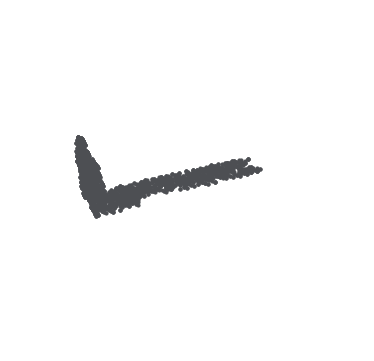

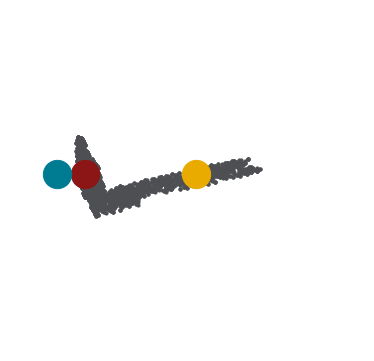

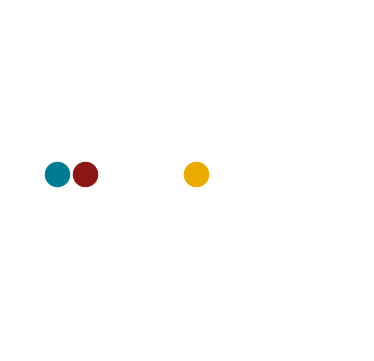

Handle trans: [-0.05792568 -0.02273397  0.        ], rot: 0.364876228631
Head trans: [-0.1945069  -0.00237264  0.        ], rot: 1.87598802483


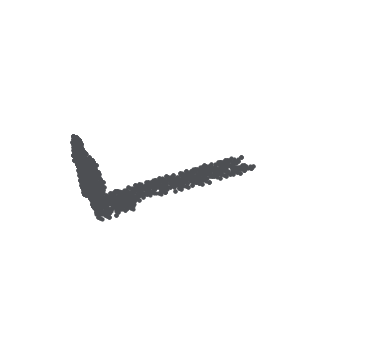

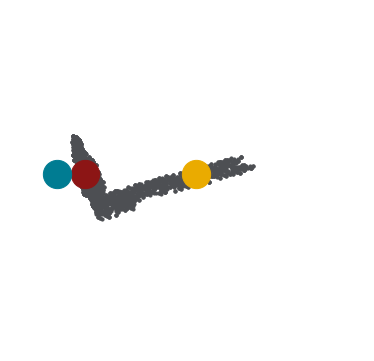

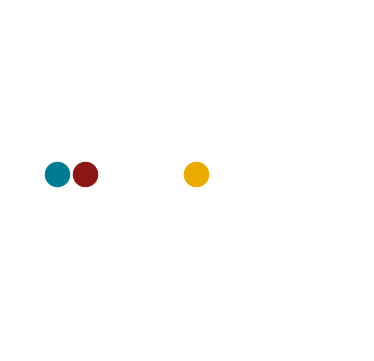

Handle trans: [-0.05936682 -0.01893845  0.        ], rot: 0.526346872151
Head trans: [-0.18639264 -0.01302031  0.        ], rot: 1.91979563308


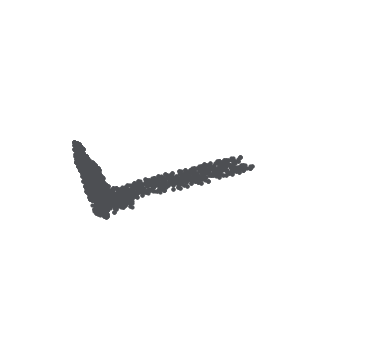

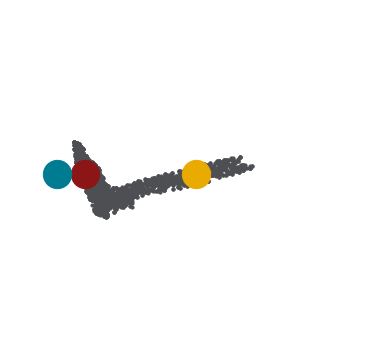

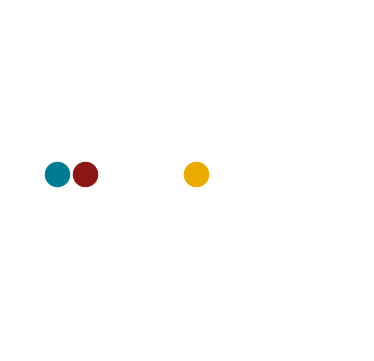

In [4]:
# Pushing

part_1 = tf.placeholder(tf.float32, [1024, 3])
part_2 = tf.placeholder(tf.float32, [1024, 3])

trans_1 = tf.placeholder(tf.float32, [3])
trans_2 = tf.placeholder(tf.float32, [3])

rot_1 = tf.placeholder(tf.float32, ())
rot_2 = tf.placeholder(tf.float32, ())

part_1_move = tf.matmul(part_1, tf.transpose(rotation_mat(rot_1), [1, 0])) + trans_1
part_2_move = tf.matmul(part_2, tf.transpose(rotation_mat(rot_2), [1, 0])) + trans_2

point_cloud = tf.concat([part_1_move, part_2_move], axis=0)
grasp_point = tf.placeholder(tf.float32, [3])
funct_point = tf.placeholder(tf.float32, [3])
funct_vect = tf.placeholder(tf.float32, [3])

score = KeypointDiscriminator().build_model(
    tf.reshape(point_cloud, [1, 2048, 1, 3]),
    [tf.reshape(grasp_point, [1, 1, 3]), tf.reshape(funct_point, [1, 1, 3])],
    tf.reshape(funct_vect, [1, 1, 3]))

score = tf.squeeze(score)

dist = tf.add_n([min_dist(part_1_move, grasp_point), 
                 min_dist(part_2_move, funct_point),
                 min_dist(part_1_move, part_2_move)])
dist = dist + tf.square(tf.cos(rot_1 - rot_2)) 
dist = dist * 100

trans_1_grad = tf.gradients(score - dist, trans_1)
trans_2_grad = tf.gradients(score - dist, trans_2)
rot_1_grad = tf.gradients(score - dist, rot_1)
rot_2_grad = tf.gradients(score - dist, rot_2)

part_1_path = '../datagen/part/handle/point_cloud.npy'
part_2_path = '../datagen/part/head/point_cloud.npy'
scale = 20

part_1_np = np.load(open(part_1_path, 'rb')) * scale
part_2_np = np.load(open(part_2_path, 'rb')) * scale


with tf.Session() as sess:
    max_iter = 400
    learning_rate = 1e-3
    grasp_point_np = np.array([0, 0, 0], dtype=np.float32)
    funct_point_np = np.array([-4, 0, 0], dtype=np.float32)
    funct_vect_np = np.array([-1, 0, 0], dtype=np.float32)
    
    trans_1_np = np.array([0, 0, 0], dtype=np.float32)
    trans_2_np = np.array([-4, 0, 0], dtype=np.float32)
    rot_1_np = 0
    rot_2_np = 1.57
    
    saver = tf.train.Saver()
    saver.restore(sess, 'keypoint_models/cvae_push')
    
    for iiter in range(max_iter):
        [trans_1_grad_np, trans_2_grad_np, 
         rot_1_grad_np, rot_2_grad_np,
         part_1_move_np, part_2_move_np, score_np] = sess.run(
            [trans_1_grad, trans_2_grad, rot_1_grad, rot_2_grad,
             part_1_move, part_2_move, score],
            feed_dict={part_1: part_1_np, part_2: part_2_np,
                       trans_1: trans_1_np, trans_2: trans_2_np,
                       rot_1: rot_1_np, rot_2: rot_2_np,
                       grasp_point: grasp_point_np, funct_point: funct_point_np, 
                       funct_vect: funct_vect_np})
        
        trans_1_np = trans_1_np + learning_rate * trans_1_grad_np[0] * np.array([1, 1, 0])
        trans_2_np = trans_2_np + learning_rate * trans_2_grad_np[0] * np.array([1, 1, 0])
        rot_1_np = rot_1_np + learning_rate * rot_1_grad_np[0] * 3
        rot_2_np = rot_2_np + learning_rate * rot_2_grad_np[0] * 3
    
        if iiter % 100 == 0:
            point_cloud_curr = np.concatenate([part_1_move_np, part_2_move_np], axis=0)
            keypoints_list = [np.reshape(grasp_point_np, [1, 3]),
                              np.reshape(funct_point_np, [1, 3]),
                              np.reshape(funct_vect_np, [1, 3])]
            print('Handle trans: {}, rot: {}'.format(trans_1_np/scale, rot_1_np))
            print('Head trans: {}, rot: {}'.format(trans_2_np/scale, rot_2_np))
            visualize_keypoints(point_cloud_curr, keypoints_list, prefix='visualize', name='%06d'%(iiter))
        

INFO:tensorflow:Restoring parameters from keypoint_models/cvae_reach
Handle trans: [-0.05425439 -0.00034677  0.        ], rot: 0.304354476929
Head trans: [ 0.00089503 -0.00081255  0.        ], rot: 1.5453883276


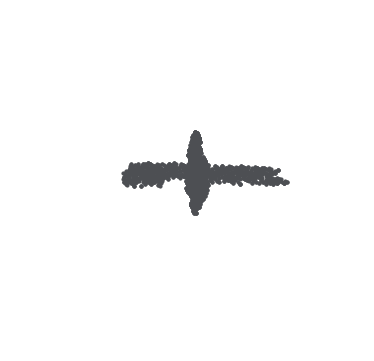

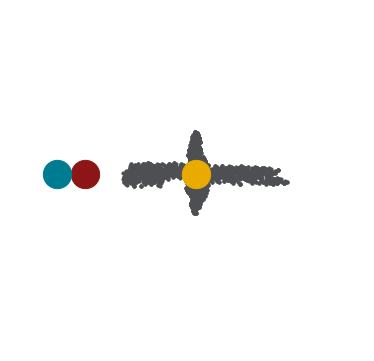

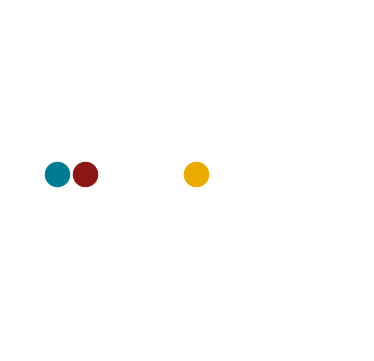

Handle trans: [-0.09482214  0.00659102  0.        ], rot: 28.198668314
Head trans: [-0.06083422  0.01524633  0.        ], rot: 0.427028851584


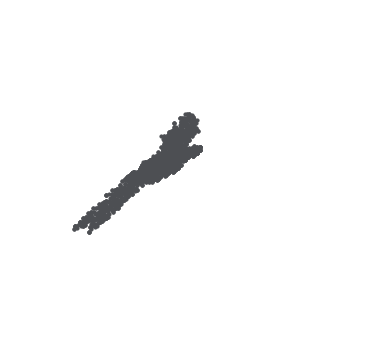

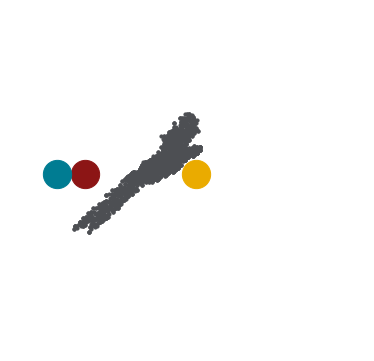

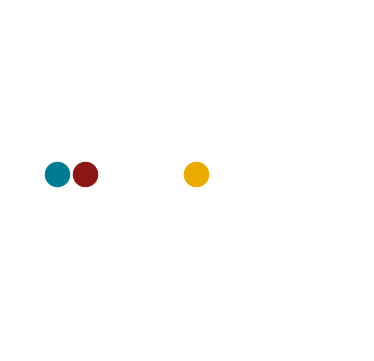

Handle trans: [-0.1027331  -0.00687665  0.        ], rot: 79.7414631901
Head trans: [-0.07337658  0.00434809  0.        ], rot: 0.660536330104


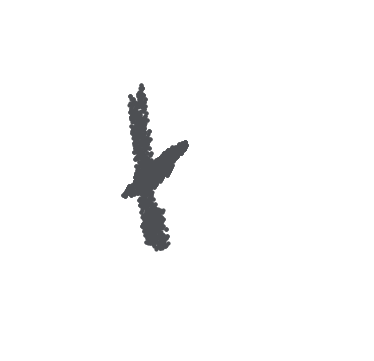

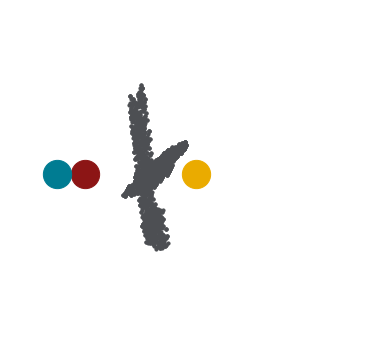

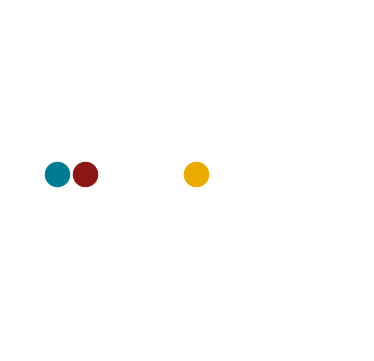

Handle trans: [-0.12938744  0.01679025  0.        ], rot: 197.296284912
Head trans: [-0.08866431  0.00168604  0.        ], rot: 0.450237744808


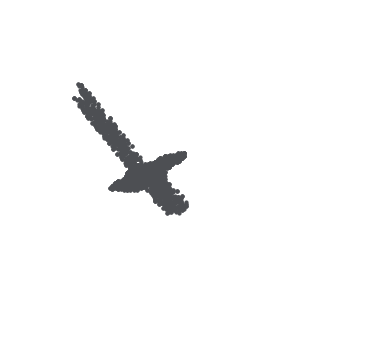

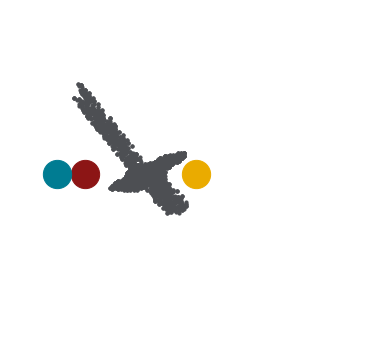

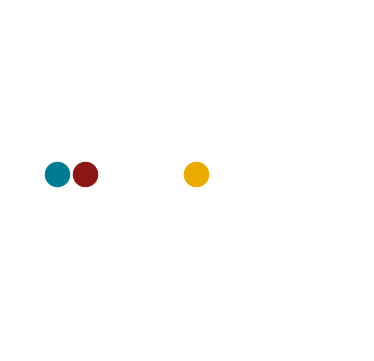

Handle trans: [-0.1121657   0.01300637  0.        ], rot: 248.455140178
Head trans: [-0.08038815  0.01525897  0.        ], rot: 0.440555758476


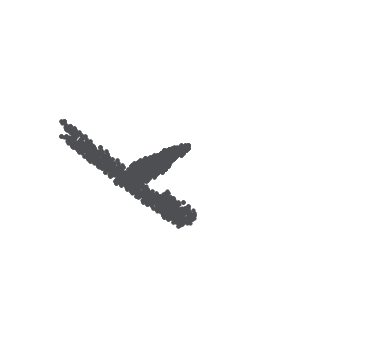

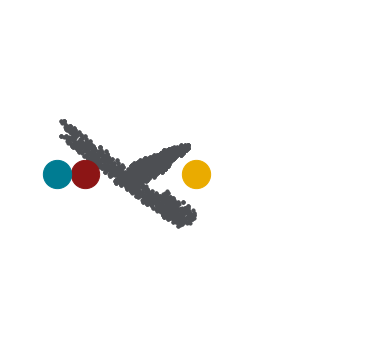

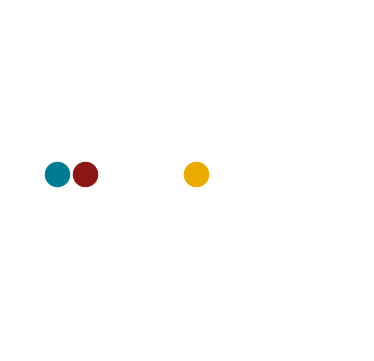

Handle trans: [-0.11264641  0.02069923  0.        ], rot: 236.832188099
Head trans: [-0.06846996  0.00416518  0.        ], rot: 0.575083312035


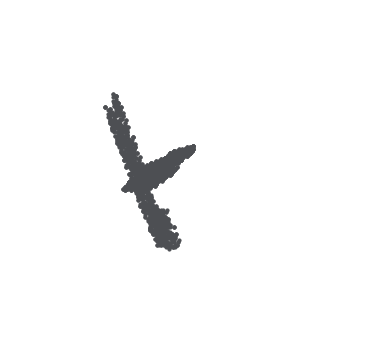

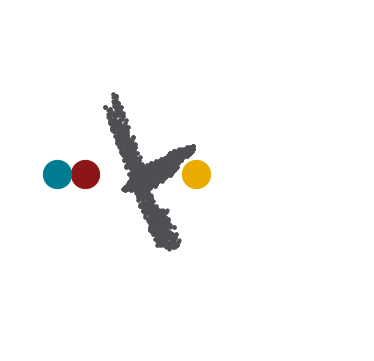

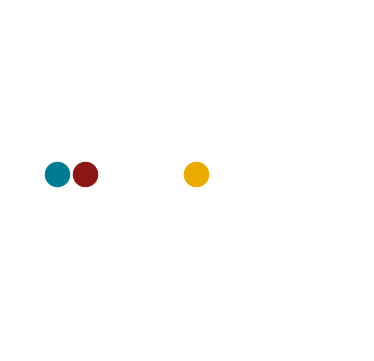

Handle trans: [-0.125746    0.03282703  0.        ], rot: 305.114947698
Head trans: [-0.09901549  0.0037781   0.        ], rot: 0.38992013979


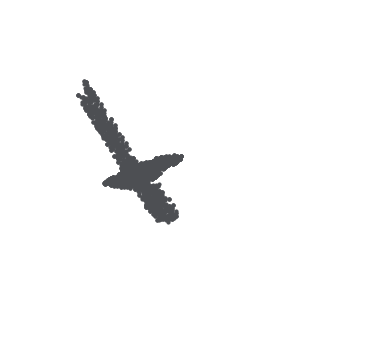

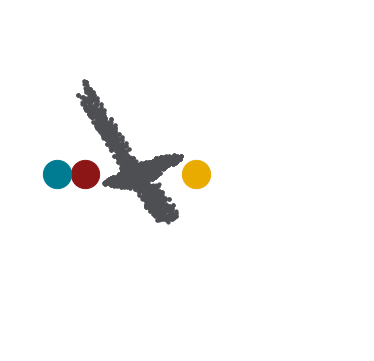

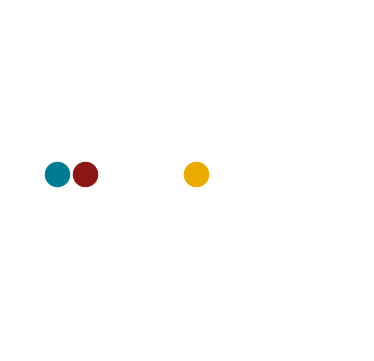

Handle trans: [-0.08790197  0.00745373  0.        ], rot: 318.147909936
Head trans: [-0.12562157 -0.00097115  0.        ], rot: -0.0147012327015


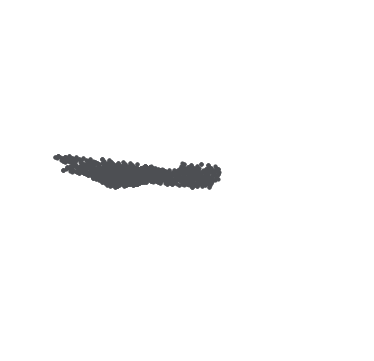

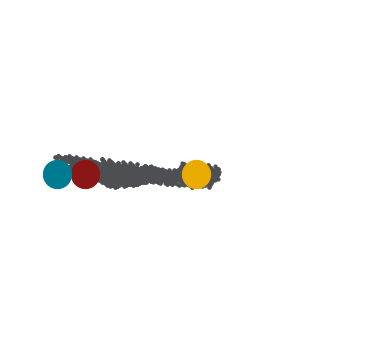

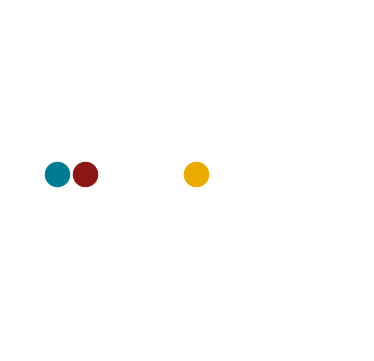

Handle trans: [-0.11616834 -0.02048788  0.        ], rot: 345.904465936
Head trans: [-0.12457734 -0.00550628  0.        ], rot: 0.00974650648236


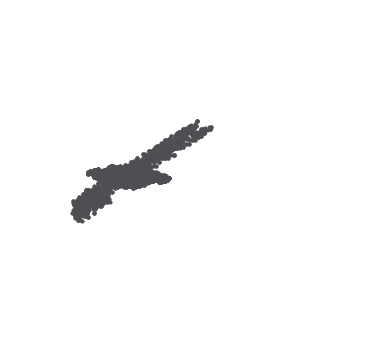

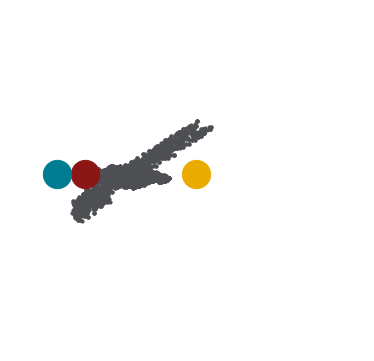

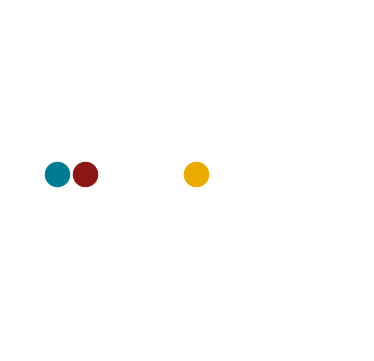

Handle trans: [-0.09578103 -0.00402563  0.        ], rot: 378.126603967
Head trans: [-0.12734375 -0.00040545  0.        ], rot: -0.0752386633456


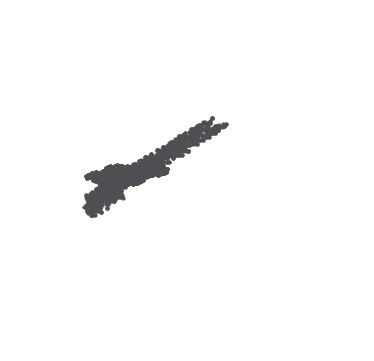

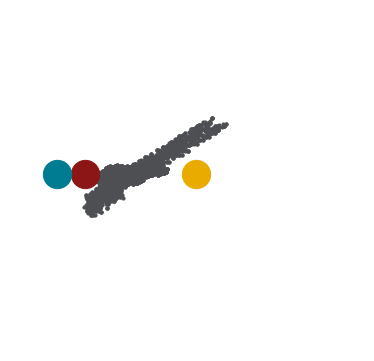

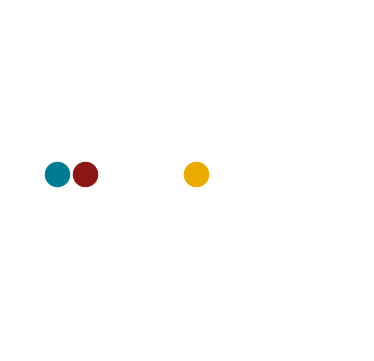

In [5]:
# Reaching

part_1 = tf.placeholder(tf.float32, [1024, 3])
part_2 = tf.placeholder(tf.float32, [1024, 3])

trans_1 = tf.placeholder(tf.float32, [3])
trans_2 = tf.placeholder(tf.float32, [3])

rot_1 = tf.placeholder(tf.float32, ())
rot_2 = tf.placeholder(tf.float32, ())

part_1_move = tf.matmul(part_1, tf.transpose(rotation_mat(rot_1), [1, 0])) + trans_1
part_2_move = tf.matmul(part_2, tf.transpose(rotation_mat(rot_2), [1, 0])) + trans_2

point_cloud = tf.concat([part_1_move, part_2_move], axis=0)
grasp_point = tf.placeholder(tf.float32, [3])
funct_point = tf.placeholder(tf.float32, [3])
funct_vect = tf.placeholder(tf.float32, [3])

score = KeypointDiscriminator().build_model(
    tf.reshape(point_cloud, [1, 2048, 1, 3]),
    [tf.reshape(grasp_point, [1, 1, 3]), tf.reshape(funct_point, [1, 1, 3])],
    tf.reshape(funct_vect, [1, 1, 3]))

score = tf.squeeze(score)

dist = tf.add_n([min_dist(part_1_move, grasp_point), 
                 min_dist(part_1_move, funct_point),
                 min_dist(part_1_move, part_2_move)])
dist = dist * 400

trans_1_grad = tf.gradients(score - dist, trans_1)
trans_2_grad = tf.gradients(score - dist, trans_2)
rot_1_grad = tf.gradients(score - dist, rot_1)
rot_2_grad = tf.gradients(score - dist, rot_2)

part_1_path = '../datagen/part/handle/point_cloud.npy'
part_2_path = '../datagen/part/head/point_cloud.npy'
scale = 20

part_1_np = np.load(open(part_1_path, 'rb')) * scale
part_2_np = np.load(open(part_2_path, 'rb')) * scale


with tf.Session() as sess:
    max_iter = 1000
    learning_rate = 1e-3
    grasp_point_np = np.array([0, 0, 0], dtype=np.float32)
    funct_point_np = np.array([-4, 0, 0], dtype=np.float32)
    funct_vect_np = np.array([-1, 0, 0], dtype=np.float32)
    
    trans_1_np = np.array([0, 0, 0], dtype=np.float32)
    trans_2_np = np.array([0, 0, 0], dtype=np.float32)
    rot_1_np = 0
    rot_2_np = 1.57
    
    saver = tf.train.Saver()
    saver.restore(sess, 'keypoint_models/cvae_reach')
    
    for iiter in range(max_iter):
        [trans_1_grad_np, trans_2_grad_np, 
         rot_1_grad_np, rot_2_grad_np,
         part_1_move_np, part_2_move_np, score_np] = sess.run(
            [trans_1_grad, trans_2_grad, rot_1_grad, rot_2_grad,
             part_1_move, part_2_move, score],
            feed_dict={part_1: part_1_np, part_2: part_2_np,
                       trans_1: trans_1_np, trans_2: trans_2_np,
                       rot_1: rot_1_np, rot_2: rot_2_np,
                       grasp_point: grasp_point_np, funct_point: funct_point_np, 
                       funct_vect: funct_vect_np})
        
        trans_1_np = trans_1_np + learning_rate * trans_1_grad_np[0] * np.array([1, 1, 0])
        trans_2_np = trans_2_np + learning_rate * trans_2_grad_np[0] * np.array([1, 1, 0])
        rot_1_np = rot_1_np + learning_rate * rot_1_grad_np[0] * 3
        rot_2_np = rot_2_np + learning_rate * rot_2_grad_np[0] * 3
    
        if iiter % 100 == 0:
            point_cloud_curr = np.concatenate([part_1_move_np, part_2_move_np], axis=0)
            keypoints_list = [np.reshape(grasp_point_np, [1, 3]),
                              np.reshape(funct_point_np, [1, 3]),
                              np.reshape(funct_vect_np, [1, 3])]
            print('Handle trans: {}, rot: {}'.format(trans_1_np/scale, rot_1_np))
            print('Head trans: {}, rot: {}'.format(trans_2_np/scale, rot_2_np))
            visualize_keypoints(point_cloud_curr, keypoints_list, prefix='visualize', name='%06d'%(iiter))
        